In [1]:
# python 3.7
# contact@leonardofilipe.com
# based on Zhang, L. implementation
# paper: https://arxiv.org/abs/0802.4411

%matplotlib notebook
import numpy              as np
import pandas             as pd
import matplotlib.pyplot  as plt

from matplotlib           import cm
from mpl_toolkits.mplot3d import axes3d

plt.style.use('seaborn')

def Heston_Calls(series):
    # Variables
    kappa = series['kappa'] # Mean Reversion Speed
    theta = series['theta'] # Long Run Variance
    sigma = series['sigma'] # Volatility of Variance
    rho   = series['rho'] # Correlation
    v0    = series['Cv0'] # Initial Variance (I use Call Implied Variance from BSM instead)
    T     = series['T'] # Time to maturity
    s0    = series['s0'] # Spot Price
    K     = series['K'] # Strike Price
    N     = 10000 # Nº of simulations
    dt    = 1/32 # Timestep granularity (related to the nº of steps being generated)

    # Calculations
    vega  =(4*kappa*theta/(sigma*sigma))
    K1    = dt*(kappa*rho/sigma-0.5)/2-rho/sigma
    K2    = dt*(kappa*rho/sigma-0.5)/2+rho/sigma
    K3    = dt*(1-rho*rho)/2
    ss    = K2+K3/2
    yita  = 4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
    sh    = ss*np.exp(-kappa*dt)/yita
    S     = np.ones(N)*s0
    v     = np.ones(N)*v0
    Ntime=int(T/dt)
    
    # Simulations
    for i in range (0,Ntime):
        Zs   = np.random.randn(1,N)
        lamb = v*yita
        W    = np.random.noncentral_chisquare(vega,lamb)
        v2   = W*np.exp(-kappa*dt)/yita
        K0   = -lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
        S    = S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
        v    = v2
    payoff=np.maximum(S-K,0)
    return np.mean(payoff)

def Heston_Puts(series):
    # Variables
    kappa = series['kappa'] # Mean Reversion Speed
    theta = series['theta'] # Long Run Variance
    sigma = series['sigma'] # Volatility of Variance
    rho   = series['rho'] # Correlation
    v0    = series['Pv0'] # Initial Variance (I use Put Implied Variance from BSM instead)
    T     = series['T'] # Time to maturity
    s0    = series['s0'] # Spot Price
    K     = series['K'] # Strike Price
    N     = 10000 # Nº of simulations
    dt    = 1/32 # Timestep granularity (related to the nº of steps being generated)

    # Calculations
    vega  = (4*kappa*theta/(sigma*sigma))
    K1    = dt*(kappa*rho/sigma-0.5)/2-rho/sigma
    K2    = dt*(kappa*rho/sigma-0.5)/2+rho/sigma
    K3    = dt*(1-rho*rho)/2
    ss    = K2+K3/2
    yita  = 4*kappa*np.exp(-kappa*dt)/(sigma*sigma)/(1-np.exp(-kappa*dt))
    sh    = ss*np.exp(-kappa*dt)/yita
    S     = np.ones(N)*s0
    v     = np.ones(N)*v0
    Ntime = int(T/dt)

    # Simulations
    for i in range (0,Ntime):
        Zs   = np.random.randn(1,N)
        lamb = v*yita
        W    = np.random.noncentral_chisquare(vega,lamb)
        v2   = W*np.exp(-kappa*dt)/yita
        K0   = -lamb*sh/(1-2*sh)+0.5*vega*np.log(1-2*sh)-(K1+K3/2)*v
        S    = S*np.exp(K0+K1*v+K2*v2+np.multiply(np.sqrt(K3*(v+v2)),Zs))
        v    = v2
    payoff=np.maximum(K-S,0)
    return np.mean(payoff)

db             = pd.read_hdf("optiondata.h5")
db['Now']      = pd.to_datetime(db['Now'])
db['Maturity'] = pd.to_datetime(db['Maturity'])

In [2]:
HTest = pd.DataFrame({'T': db['Expiration'],'Cv0': db['CallImpVol']**2, 'Now': db['Now'],
                     's0': db['Spot'],'Pv0': db['PutImpVol']**2,'Put': db['PutMid'],
                     'K': db['Strike'],'Call': db['CallMid'],'Maturity': db['Maturity']})

HTest[HTest['Cv0'] < 0.001] = 0
HTest[HTest['Pv0'] < 0.001] = 0
HTest = HTest.loc[(HTest!=0).any(1)]
HTest = HTest.reset_index().drop('index',axis=1)

# Calibration can still be improved
HTest['Moneyness'] = abs(HTest['K']/HTest['s0'])
HTest['theta'] = 0.0722
HTest['kappa'] = 0.4816
HTest['sigma'] = 0.621
HTest['rho']   = -0.5527

In [3]:
HTest['Heston Call'] = round(HTest.apply(Heston_Calls, axis=1),2)
HTest['CError'] = abs(HTest['Heston Call']/HTest['Call']-1)
HTest['CError'].describe()

count    429.000000
mean       0.177568
std        0.159545
min        0.000386
25%        0.091800
50%        0.152254
75%        0.188938
max        0.868657
Name: CError, dtype: float64

In [4]:
HTest['Heston Put'] = round(HTest.apply(Heston_Puts, axis=1),2)
HTest['PError'] = abs(HTest['Heston Put']/HTest['Put']-1)
HTest['PError'].describe()

count    429.000000
mean       0.093806
std        0.041293
min        0.000239
25%        0.064486
50%        0.101762
75%        0.125947
max        0.203253
Name: PError, dtype: float64

In [5]:
HTest.groupby('Maturity')['CError'].describe()

,count,mean,std,min,25%,50%,75%,max
Maturity,,,,,,,,
2018-05-18 17:30:00,39.0,0.451255,0.283261,0.002766,0.199734,0.484938,0.709154,0.822857
2018-06-15 17:30:00,62.0,0.156919,0.083259,0.005128,0.083065,0.177897,0.220694,0.347368
2018-09-21 17:30:00,105.0,0.152429,0.152525,0.002740,0.079245,0.132809,0.154208,0.868657
2018-12-21 17:30:00,125.0,0.137622,0.114624,0.000386,0.051094,0.131896,0.182227,0.567401
2019-03-15 17:30:00,98.0,0.159601,0.036463,0.041959,0.137607,0.172851,0.185618,0.223236


In [6]:
HTest.groupby('Maturity')['PError'].describe()

,count,mean,std,min,25%,50%,75%,max
Maturity,,,,,,,,
2018-05-18 17:30:00,39.0,0.130925,0.036927,0.065993,0.106162,0.126740,0.155706,0.203253
2018-06-15 17:30:00,62.0,0.060654,0.015233,0.018222,0.050768,0.061104,0.074580,0.085125
2018-09-21 17:30:00,105.0,0.098113,0.037721,0.002030,0.075870,0.104823,0.125951,0.162798
2018-12-21 17:30:00,125.0,0.102391,0.040796,0.003227,0.084165,0.115402,0.130891,0.161938
2019-03-15 17:30:00,98.0,0.084444,0.041596,0.000239,0.056634,0.088544,0.117916,0.162074


<IPython.core.display.Javascript object>


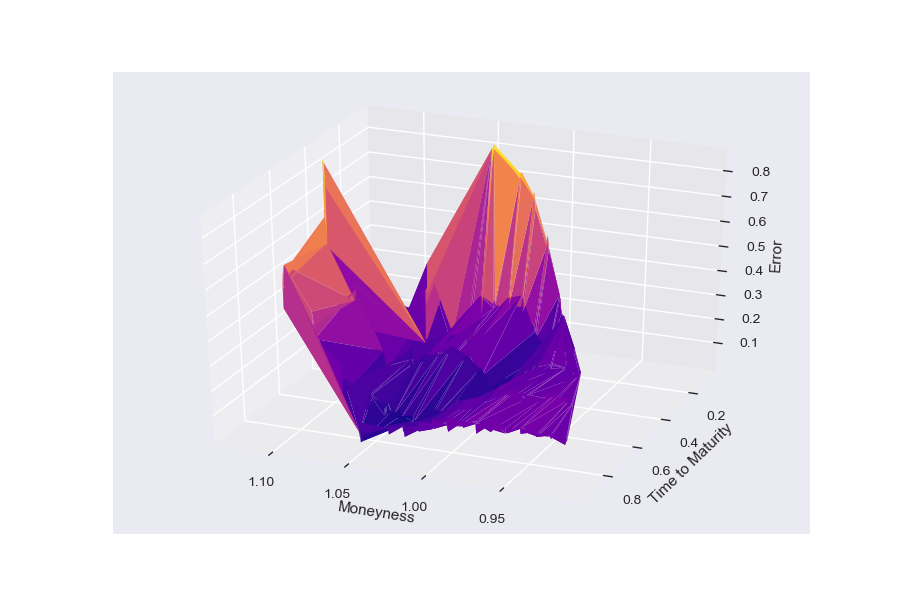

In [7]:
fig = plt.figure(figsize=(9,6))
ax  = fig.gca(projection='3d')
ax.plot_trisurf(HTest['Moneyness'], HTest['T'], abs(HTest['CError']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Error')

ax.dist=12
ax.view_init(30, 112.5)
plt.show()

<IPython.core.display.Javascript object>


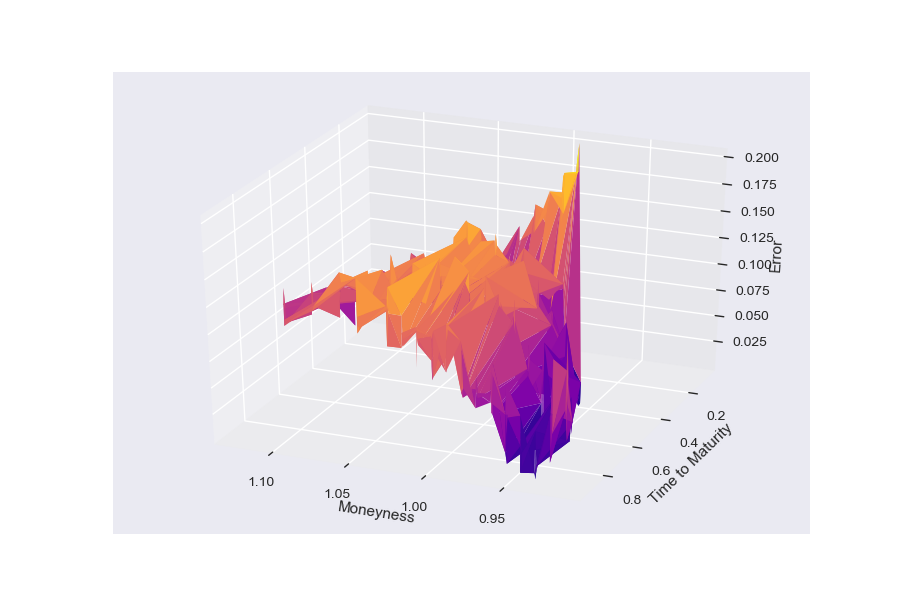

In [8]:
fig = plt.figure(figsize=(9,6))
ax  = fig.gca(projection='3d')
ax.plot_trisurf(HTest['Moneyness'], HTest['T'], abs(HTest['PError']), cmap=cm.plasma, linewidth=0.1)

ax.set_xlabel('Moneyness')
ax.set_ylabel('Time to Maturity')
ax.set_zlabel('Error')

ax.dist=12
ax.view_init(30, 112.5)
plt.show()